**Goal**<br>
The goal of this exercise is to generate the information plane studied in class for a multilayer perceptron trained on the MNIST dataset (projected to 12 dimensions using PCA).

*Before you start, make sure to change the runtime type to include a GPU!*

<br>

**Task (adding two lines of code)**<br>
Implement the calculation of the empirical mutual informations $\hat{I} (X;H)$ and $\hat{I} (Y;H)$.

Hint: use the python functions sum and math.log2

<br>

**Submission**<br>
*   Download your code by clicking File -> Download .ipynb
*   Submit your downloaded code on Quercus

In [1]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models
import torch.nn.utils.prune as prune
from tqdm import tqdm
import copy

from collections import Counter
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset
from torchvision import datasets, transforms
from mine.models.mine import Mine

Device: cuda


In [2]:
# hyperparameters
device        = 'cuda'
lr            = 7e-2
epochs        = 20
milestones    = [epochs//2]
gamma         = 0.5
batch_size    = 512
momentum      = 0
weight_decay  = 0
n_bins        = 20
prune_iters   = 10

In [3]:
# deep network
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(12, 10)
        self.fc2 = nn.Linear(10, 7)
        self.fc3 = nn.Linear(7, 5)
        self.fc4 = nn.Linear(5, 4)
        self.fc5 = nn.Linear(4, 3)
        self.fc6 = nn.Linear(3, 2)

    def forward(self, x):
        h1 = torch.tanh(self.fc1(x))
        h2 = torch.tanh(self.fc2(h1))
        h3 = torch.tanh(self.fc3(h2))
        h4 = torch.tanh(self.fc4(h3))
        h5 = torch.tanh(self.fc5(h4))
        h6 = F.log_softmax(self.fc6(h5), dim=1)
        return h1, h2, h3, h4, h5, h6

model = Model().to(device)

def process_dataset(dataset):
    # keep only images of two digits
    digit1 = 0
    digit2 = 2

    indices = (dataset.targets == digit1) | (dataset.targets == digit2)
    dataset.data, dataset.targets = dataset.data[indices], dataset.targets[indices]

    dataset.targets[dataset.targets == digit1] = 0
    dataset.targets[dataset.targets == digit2] = 1

    dataset = TensorDataset(dataset.data.reshape(-1, 28*28), dataset.targets)

    return dataset

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = process_dataset(datasets.MNIST('../data', download=True, train=True, transform=transform))
test_dataset = process_dataset(datasets.MNIST('../data', download=True, train=False, transform=transform))

# use PCA to reduce to 12 dimensions
pca = PCA(n_components=12)
pca.fit(train_dataset.tensors[0])
train_dataset.tensors = (torch.from_numpy(pca.transform(train_dataset.tensors[0])).float(), train_dataset.tensors[1])
test_dataset.tensors = (torch.from_numpy(pca.transform(test_dataset.tensors[0])).float(), test_dataset.tensors[1])

train_dataset, val_dataset =  torch.utils.data.random_split(train_dataset, [0.9, 0.1])
# dataset loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

train_loader_full = torch.utils.data.DataLoader(
    train_dataset, batch_size=len(train_loader.dataset), shuffle=False, drop_last=False)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

# loss function
loss_function = nn.NLLLoss()

# optimizer
optimizer = optim.SGD(model.parameters(),
                      lr=lr,
                      momentum=momentum,
                      weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

In [4]:
data, labels = next(iter(train_loader_full))

In [5]:
print(data.mean())
print(data.std())

tensor(0.3342)
tensor(436.4931)


# New Section

In [6]:
inital_state_dict = copy.deepcopy(model.state_dict())

In [7]:
def set_init_param(model, init_state_dict):
    mask = []
    for name, module in model.named_modules():
        if prune.is_pruned(module):
            if isinstance(module, torch.nn.Linear):
                mask.append(module.weight_mask)
                prune.remove(module, 'weight')

    model.load_state_dict(init_state_dict)
    i = 0
    for name, module in model.named_modules():
        if len(mask) > 0:
            if isinstance(module, torch.nn.Linear):
                prune.custom_from_mask(module, 'weight', mask[i])
                i+=1


In [8]:
def count_zeros(model):
    for name, buf in model.named_buffers():
        print(f'{name}: Percentage {buf.sum()}/{buf.numel()} =  {buf.sum()/buf.numel()}')

In [9]:
count_zeros(model)

In [10]:
def train_epoch(model, train_loader, loss_function, optimizer, device, epoch):
    model.train()
    accuracy = 0.0
    N = 0
    cumulative_loss = 0
    # iterate over train data
    for batch_idx, (images, labels) in enumerate(train_loader, start=1):
        images, labels = images.to(device), labels.to(device)

        # forward pass
        h1, h2, h3, h4, h5, h6 = model(images)
        loss = loss_function(h6, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(h6, dim=1)
        accuracy += torch.sum((predicted_labels == labels).float()).item()
        N += images.shape[0]
        cumulative_loss += loss.item() * images.shape[0]


    return 100. * accuracy / N, cumulative_loss/len(train_loader)

In [11]:
def val_epoch(model, test_loader, device, loss_function):
    model.eval()
    accuracy = 0
    N = 0
    cumulative_loss = 0

    # iterate over test data
    for batch_idx, (images, labels) in enumerate(test_loader, start=1):
        images, labels = images.to(device), labels.to(device)

        # forward pass
        h1, h2, h3, h4, h5, h6 = model(images)
        loss = loss_function(h6, labels)


        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(h6, dim=1)
        accuracy += torch.sum((predicted_labels == labels).float()).item()
        N += images.shape[0]
        cumulative_loss += loss.item() * images.shape[0]

    return 100. * accuracy / N, cumulative_loss / N

In [12]:
def calculate_mutual_information(model, train_loader_full, n_bins, device):
    """
    Calculate mutual information for different layers in a neural network.

    Parameters:
    - model: The neural network model.
    - train_loader_full: The data loader for training data.
    - n_bins: The number of bins for discretization.
    - layers: The number of layers in the neural network.
    - device: The device on which to perform calculations (e.g., 'cuda' or 'cpu').

    Returns:
    - MI_XH: Mutual information for input and hidden layers.
    - MI_YH: Mutual information for label and hidden layers.
    """
    layers = len(list(model.children()))


    for images, labels in train_loader_full:
        images, labels = images.to(device), labels.to(device)
    h_list = model(images)
    images = (images - images.mean())/images.std()

    MI_XH = torch.zeros(len(h_list))
    MI_YH = torch.zeros(len(h_list))
    X = images.reshape(images.shape[0], -1)
    Y = labels.unsqueeze(1)
    for layer, h in enumerate(h_list):
        h = h.detach()

        statistics_network = nn.Sequential(
            nn.Linear(X.shape[1] + h.shape[1], 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )   
        statistics_network_hy = nn.Sequential(
            nn.Linear(Y.shape[1] + h.shape[1], 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )
        statistics_network.to(device)
        statistics_network_hy.to(device)

        mine = Mine(
            T = statistics_network,
            loss = 'mine', #mine_biased, fdiv
            method = 'concat'
        )
        mine2 = Mine(
            T = statistics_network_hy,
            loss = 'mine', #mine_biased, fdiv
            method = 'concat'
        )
        
        mi_xh = mine.optimize(X, h, iters = 100, batch_size=1024)
        mi_yh = mine2.optimize(Y, h, iters = 100, batch_size=1024)
        MI_XH[layer] = mi_xh
        MI_YH[layer] = mi_yh
        #bins = np.linspace(0, 1, n_bins + 1)
        #x_ = np.digitize(images.cpu(), bins)

        #if layer == layers - 1:
        #    h = torch.exp(h)
        #    bins = np.linspace(0, 1, n_bins + 1)
        #else:
        #    bins = np.linspace(-1, 1, n_bins + 1)

        #h_ = np.digitize(h.cpu().detach().numpy(), bins)
        #y_ = labels.cpu()

        #p_X = Counter()
        #p_Y = Counter()
        #p_H = Counter()
        #p_XH = Counter()
        #p_YH = Counter()

        #for x_i, h_i, y_i in zip(x_, h_, y_):
        #    def totuple(a):
        #        try:
        #            return tuple(totuple(i) for i in a)
        #        except:
        #            return a.item()

        #    unit = 1. / len(images)
        #    p_X[totuple(x_i)] += unit
        #    p_Y[totuple(y_i)] += unit
        #    p_H[totuple(h_i)] += unit
        #    p_XH[(totuple(x_i), totuple(h_i))] += unit
        #    p_YH[(totuple(y_i), totuple(h_i))] += unit

        #MI_XH[layer] = sum(
        #    [p_XH[key] * (np.log2(p_XH[key]) - np.log2(p_X[key[0]]) - np.log2(p_H[key[1]])) for key in
        #        p_XH.keys()])
        #MI_YH[layer] = sum(
        #    [p_YH[key] * (np.log2(p_YH[key]) - np.log2(p_Y[key[0]]) - np.log2(p_H[key[1]])) for key in
        #        p_YH.keys()]) 

    return MI_XH, MI_YH

In [13]:
train_accuracy = torch.zeros(prune_iters, epochs)
train_loss = torch.zeros(prune_iters, epochs)
val_accuracy = torch.zeros(prune_iters, epochs)
val_loss = torch.zeros(prune_iters, epochs)
best_epoch = torch.zeros(prune_iters)
best_model_weights = []
torch.autograd.set_detect_anomaly(True)
# mutual informations for every epoch and every layer
layers = len(list(model.children()))
MI_XH = torch.zeros(prune_iters, epochs, layers)
MI_YH = torch.zeros(prune_iters, epochs, layers)

for prune_i in range(prune_iters):
# iterate over epochs
    best_accuracy = 0

    if prune_i != 0:
        set_init_param(model, inital_state_dict)
        count_zeros(model)
    model.to(device)
    optimizer = optim.SGD(model.parameters(),
                      lr=lr,
                      momentum=momentum,
                      weight_decay=weight_decay)
    pbar = tqdm(range(epochs))
    for epoch in pbar:


        # ADD CODE HERE
        mi_layer_xh, mi_layer_yh = calculate_mutual_information(model, train_loader_full, n_bins, device)
        MI_XH[prune_i, epoch, :] = mi_layer_xh
        MI_YH[prune_i, epoch, :] = mi_layer_yh

        # train phase
        model.train()
        accuracy = 0
        N = 0

        cur_train_accuracy, loss = train_epoch(model, train_loader, loss_function, optimizer, device, epoch)
        train_accuracy[prune_i, epoch] = cur_train_accuracy
        train_loss[prune_i, epoch] = loss

        #scheduler.step()

        accuracy, loss = val_epoch(model, val_loader, device, loss_function)
        val_accuracy[prune_i, epoch] = accuracy
        val_loss[prune_i, epoch] = loss


        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_epoch[prune_i] = epoch
            if len(best_model_weights) == prune_i:
                best_model_weights.append(copy.deepcopy(model.state_dict()))
            else:
                best_model_weights[prune_i] = copy.deepcopy(model.state_dict())
        pbar.set_description(f'Train Epoch: {epoch}/{epochs} Loss: {loss:.6f} Train Accuracy: {cur_train_accuracy: .2f} Val Accuracy: {accuracy:.2f}% Best Accuracy: {best_accuracy:.2f}%')


    #PRUNING
    for name, module in model.named_modules():
        # prune 20% of connections in all linear layers
        if name == 'fc6':
            prune.l1_unstructured(module, name='weight', amount=0.1)
        elif isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=0.2)


  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 9/10 Loss: 0.104238 Train Accuracy:  97.51 Val Accuracy: 97.73% Best Accuracy: 97.73%: 100%|██████████| 10/10 [08:24<00:00, 50.47s/it]


fc1.weight_mask: Percentage 96.0/120 =  0.8000000715255737
fc2.weight_mask: Percentage 56.0/70 =  0.800000011920929
fc3.weight_mask: Percentage 28.0/35 =  0.800000011920929
fc4.weight_mask: Percentage 16.0/20 =  0.800000011920929
fc5.weight_mask: Percentage 10.0/12 =  0.8333333730697632
fc6.weight_mask: Percentage 5.0/6 =  0.8333333730697632


Train Epoch: 9/10 Loss: 0.112337 Train Accuracy:  97.51 Val Accuracy: 97.39% Best Accuracy: 97.64%: 100%|██████████| 10/10 [07:43<00:00, 46.32s/it]


fc1.weight_mask: Percentage 77.0/120 =  0.6416667103767395
fc2.weight_mask: Percentage 45.0/70 =  0.6428571343421936
fc3.weight_mask: Percentage 22.0/35 =  0.6285714507102966
fc4.weight_mask: Percentage 13.0/20 =  0.6500000357627869
fc5.weight_mask: Percentage 8.0/12 =  0.6666666865348816
fc6.weight_mask: Percentage 5.0/6 =  0.8333333730697632


Train Epoch: 9/10 Loss: 0.104043 Train Accuracy:  97.16 Val Accuracy: 96.89% Best Accuracy: 97.56%: 100%|██████████| 10/10 [08:01<00:00, 48.11s/it]


fc1.weight_mask: Percentage 62.0/120 =  0.5166667103767395
fc2.weight_mask: Percentage 36.0/70 =  0.5142857432365417
fc3.weight_mask: Percentage 18.0/35 =  0.5142857432365417
fc4.weight_mask: Percentage 10.0/20 =  0.5
fc5.weight_mask: Percentage 6.0/12 =  0.5
fc6.weight_mask: Percentage 5.0/6 =  0.8333333730697632


Train Epoch: 9/10 Loss: 0.097104 Train Accuracy:  97.73 Val Accuracy: 97.56% Best Accuracy: 97.56%: 100%|██████████| 10/10 [08:07<00:00, 48.78s/it]


fc1.weight_mask: Percentage 50.0/120 =  0.4166666865348816
fc2.weight_mask: Percentage 29.0/70 =  0.41428571939468384
fc3.weight_mask: Percentage 14.0/35 =  0.4000000059604645
fc4.weight_mask: Percentage 8.0/20 =  0.4000000059604645
fc5.weight_mask: Percentage 5.0/12 =  0.4166666865348816
fc6.weight_mask: Percentage 5.0/6 =  0.8333333730697632


Train Epoch: 9/10 Loss: 0.109564 Train Accuracy:  97.80 Val Accuracy: 97.39% Best Accuracy: 97.47%: 100%|██████████| 10/10 [08:16<00:00, 49.62s/it]


fc1.weight_mask: Percentage 40.0/120 =  0.3333333432674408
fc2.weight_mask: Percentage 23.0/70 =  0.3285714387893677
fc3.weight_mask: Percentage 11.0/35 =  0.3142857253551483
fc4.weight_mask: Percentage 6.0/20 =  0.30000001192092896
fc5.weight_mask: Percentage 4.0/12 =  0.3333333432674408
fc6.weight_mask: Percentage 5.0/6 =  0.8333333730697632


Train Epoch: 9/10 Loss: 0.127747 Train Accuracy:  97.29 Val Accuracy: 96.89% Best Accuracy: 96.89%: 100%|██████████| 10/10 [08:46<00:00, 52.61s/it]


fc1.weight_mask: Percentage 32.0/120 =  0.2666666805744171
fc2.weight_mask: Percentage 18.0/70 =  0.2571428716182709
fc3.weight_mask: Percentage 9.0/35 =  0.2571428716182709
fc4.weight_mask: Percentage 5.0/20 =  0.25
fc5.weight_mask: Percentage 3.0/12 =  0.25
fc6.weight_mask: Percentage 5.0/6 =  0.8333333730697632


Train Epoch: 9/10 Loss: 0.148171 Train Accuracy:  96.70 Val Accuracy: 96.46% Best Accuracy: 96.46%: 100%|██████████| 10/10 [08:07<00:00, 48.78s/it]


fc1.weight_mask: Percentage 26.0/120 =  0.21666668355464935
fc2.weight_mask: Percentage 14.0/70 =  0.20000000298023224
fc3.weight_mask: Percentage 7.0/35 =  0.20000000298023224
fc4.weight_mask: Percentage 4.0/20 =  0.20000000298023224
fc5.weight_mask: Percentage 2.0/12 =  0.1666666716337204
fc6.weight_mask: Percentage 5.0/6 =  0.8333333730697632


Train Epoch: 9/10 Loss: 0.190850 Train Accuracy:  94.74 Val Accuracy: 94.70% Best Accuracy: 94.87%: 100%|██████████| 10/10 [07:51<00:00, 47.16s/it]


fc1.weight_mask: Percentage 21.0/120 =  0.17500001192092896
fc2.weight_mask: Percentage 11.0/70 =  0.15714286267757416
fc3.weight_mask: Percentage 6.0/35 =  0.17142857611179352
fc4.weight_mask: Percentage 3.0/20 =  0.15000000596046448
fc5.weight_mask: Percentage 2.0/12 =  0.1666666716337204
fc6.weight_mask: Percentage 5.0/6 =  0.8333333730697632


Train Epoch: 9/10 Loss: 0.226421 Train Accuracy:  94.77 Val Accuracy: 95.20% Best Accuracy: 95.29%: 100%|██████████| 10/10 [07:39<00:00, 45.95s/it]


fc1.weight_mask: Percentage 17.0/120 =  0.14166668057441711
fc2.weight_mask: Percentage 9.0/70 =  0.12857143580913544
fc3.weight_mask: Percentage 5.0/35 =  0.1428571492433548
fc4.weight_mask: Percentage 2.0/20 =  0.10000000149011612
fc5.weight_mask: Percentage 2.0/12 =  0.1666666716337204
fc6.weight_mask: Percentage 5.0/6 =  0.8333333730697632


Train Epoch: 9/10 Loss: 0.228887 Train Accuracy:  95.24 Val Accuracy: 95.03% Best Accuracy: 95.29%: 100%|██████████| 10/10 [08:04<00:00, 48.46s/it]


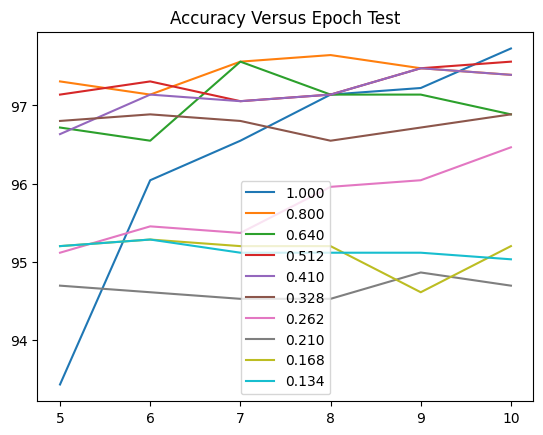

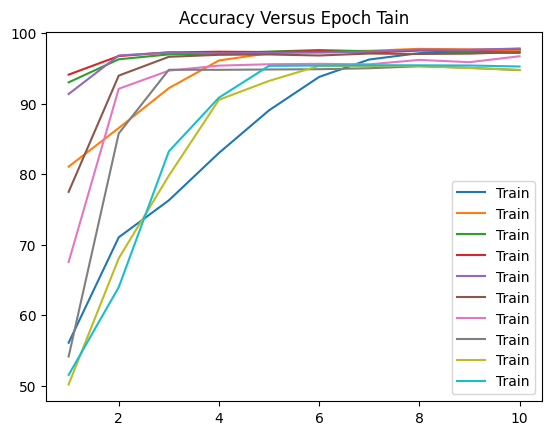

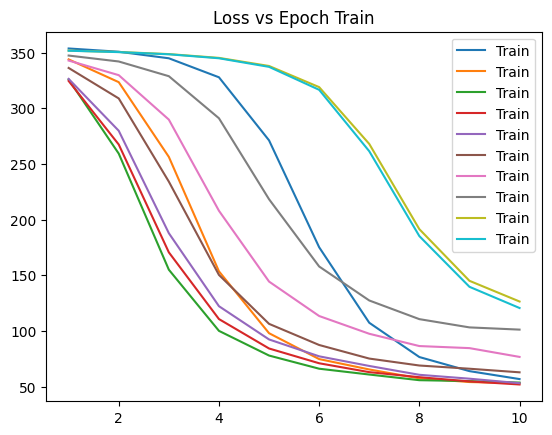

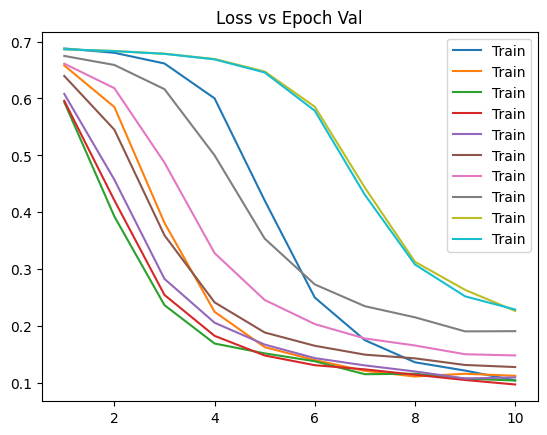

In [14]:
# plot results
plt.figure()
plt.title('Accuracy Versus Epoch Test')
lines = plt.plot(range(5, epochs+1), val_accuracy.T[4:])
[line.set_label(f'{0.8**i:.3f}') for i, line in enumerate(lines)]
plt.legend()

plt.figure()
plt.title('Accuracy Versus Epoch Tain')
plt.plot(range(1, epochs+1), train_accuracy.T, label='Train')
[line.set_label(f'{0.8**i:.3f}') for i, line in enumerate(lines)]
plt.legend()

plt.figure()
plt.title('Loss vs Epoch Train')
plt.plot(range(1, epochs+1), train_loss.T, label='Train')
[line.set_label(f'{0.8**i:.3f}') for i, line in enumerate(lines)]
plt.legend()

plt.figure()
plt.title('Loss vs Epoch Val')
plt.plot(range(1, epochs+1), val_loss.T, label='Train')
[line.set_label(f'{0.8**i:.3f}') for i, line in enumerate(lines)]
plt.legend()

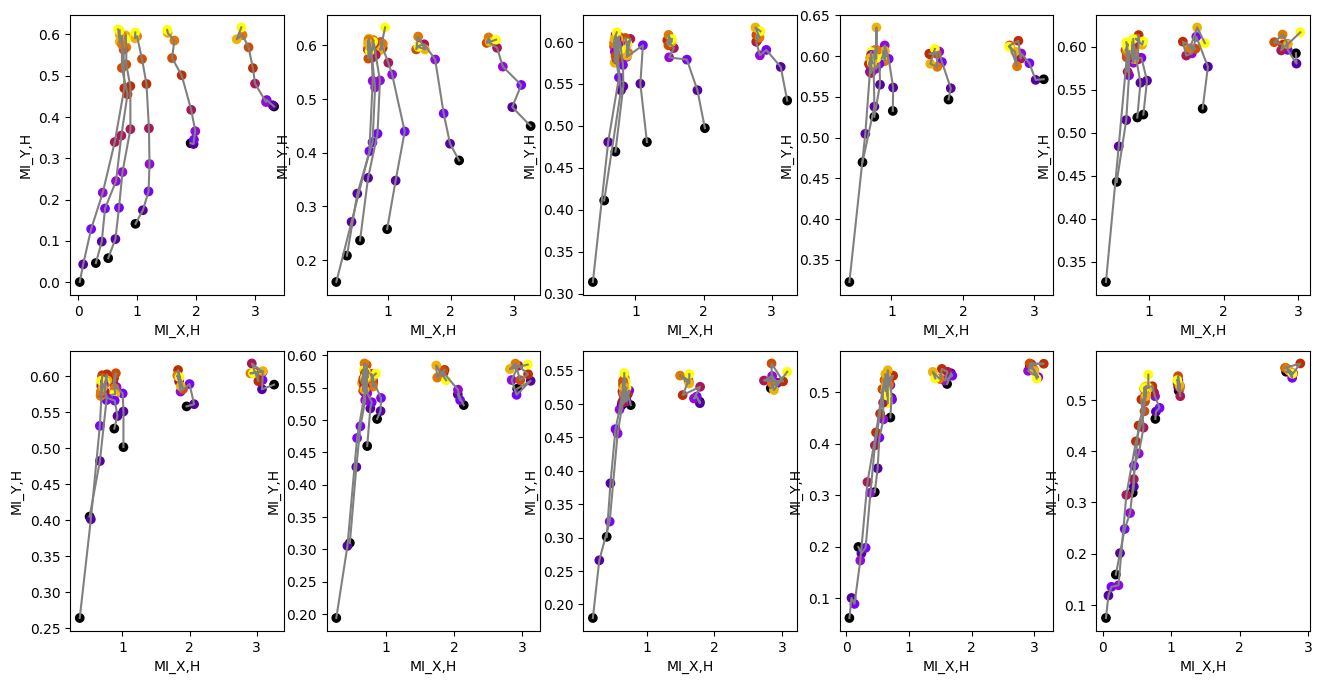

In [15]:
fig, ax = plt.subplots(2, 5, figsize=(16, 8))
for i in range(10):
    cur_ax = ax[i//5, i%5]
    cur_ax.set_xlabel('MI_X,H')
    cur_ax.set_ylabel('MI_Y,H')
    #title = cur_ax.set_title('Information Plane')
    cmap = plt.get_cmap('gnuplot', epochs)
    colors = [cmap(i) for i in np.linspace(0, 1, epochs)]
    cur_ax.plot(MI_XH[i], MI_YH[i], '-', color='gray')
    for layer in range(layers):
        cur_ax.scatter(MI_XH[i, :,layer], MI_YH[i, :,layer], c=colors)
        #cur_ax.scatter(MI_XH[i, best_epoch[i],layer], MI_YH[i, best_epoch[i],layer], c="red", s=2)